In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=acb77c2933955f4f5338d063fe61bb68a677ceff0b609d78c355c6faaf76f038
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import warnings
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as c_map
from IPython.display import Image, display
import tensorflow as tf
from tensorflow import keras
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess_input
from keras.applications.xception import decode_predictions as xception_decode_predictions
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from keras.applications.resnet50 import decode_predictions as resnet50_decode_predictions
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from keras.applications.vgg19 import decode_predictions as vgg19_decode_predictions
from keras.preprocessing import image


import lime
from lime import lime_image
from lime import submodular_pick

from skimage.segmentation import mark_boundaries, slic
from skimage.io import imread
from google.colab import drive

In [ ]:
np.random.seed(10)
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
drive.mount('/content/gdrive')

Mounted at /content/gdrive


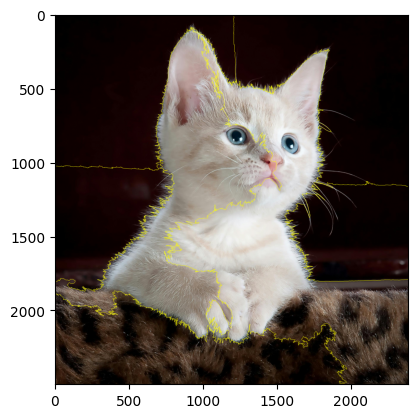

In [ ]:
cat_image_path = 'gdrive/MyDrive/Colab Notebooks/images/cat.jpg'
### Experimenting with slic and image segmentation
cat = imread(cat_image_path)
segment = slic(cat, n_segments=10)
outlined = mark_boundaries(cat, segment)
plt.imshow(outlined)
plt.show()

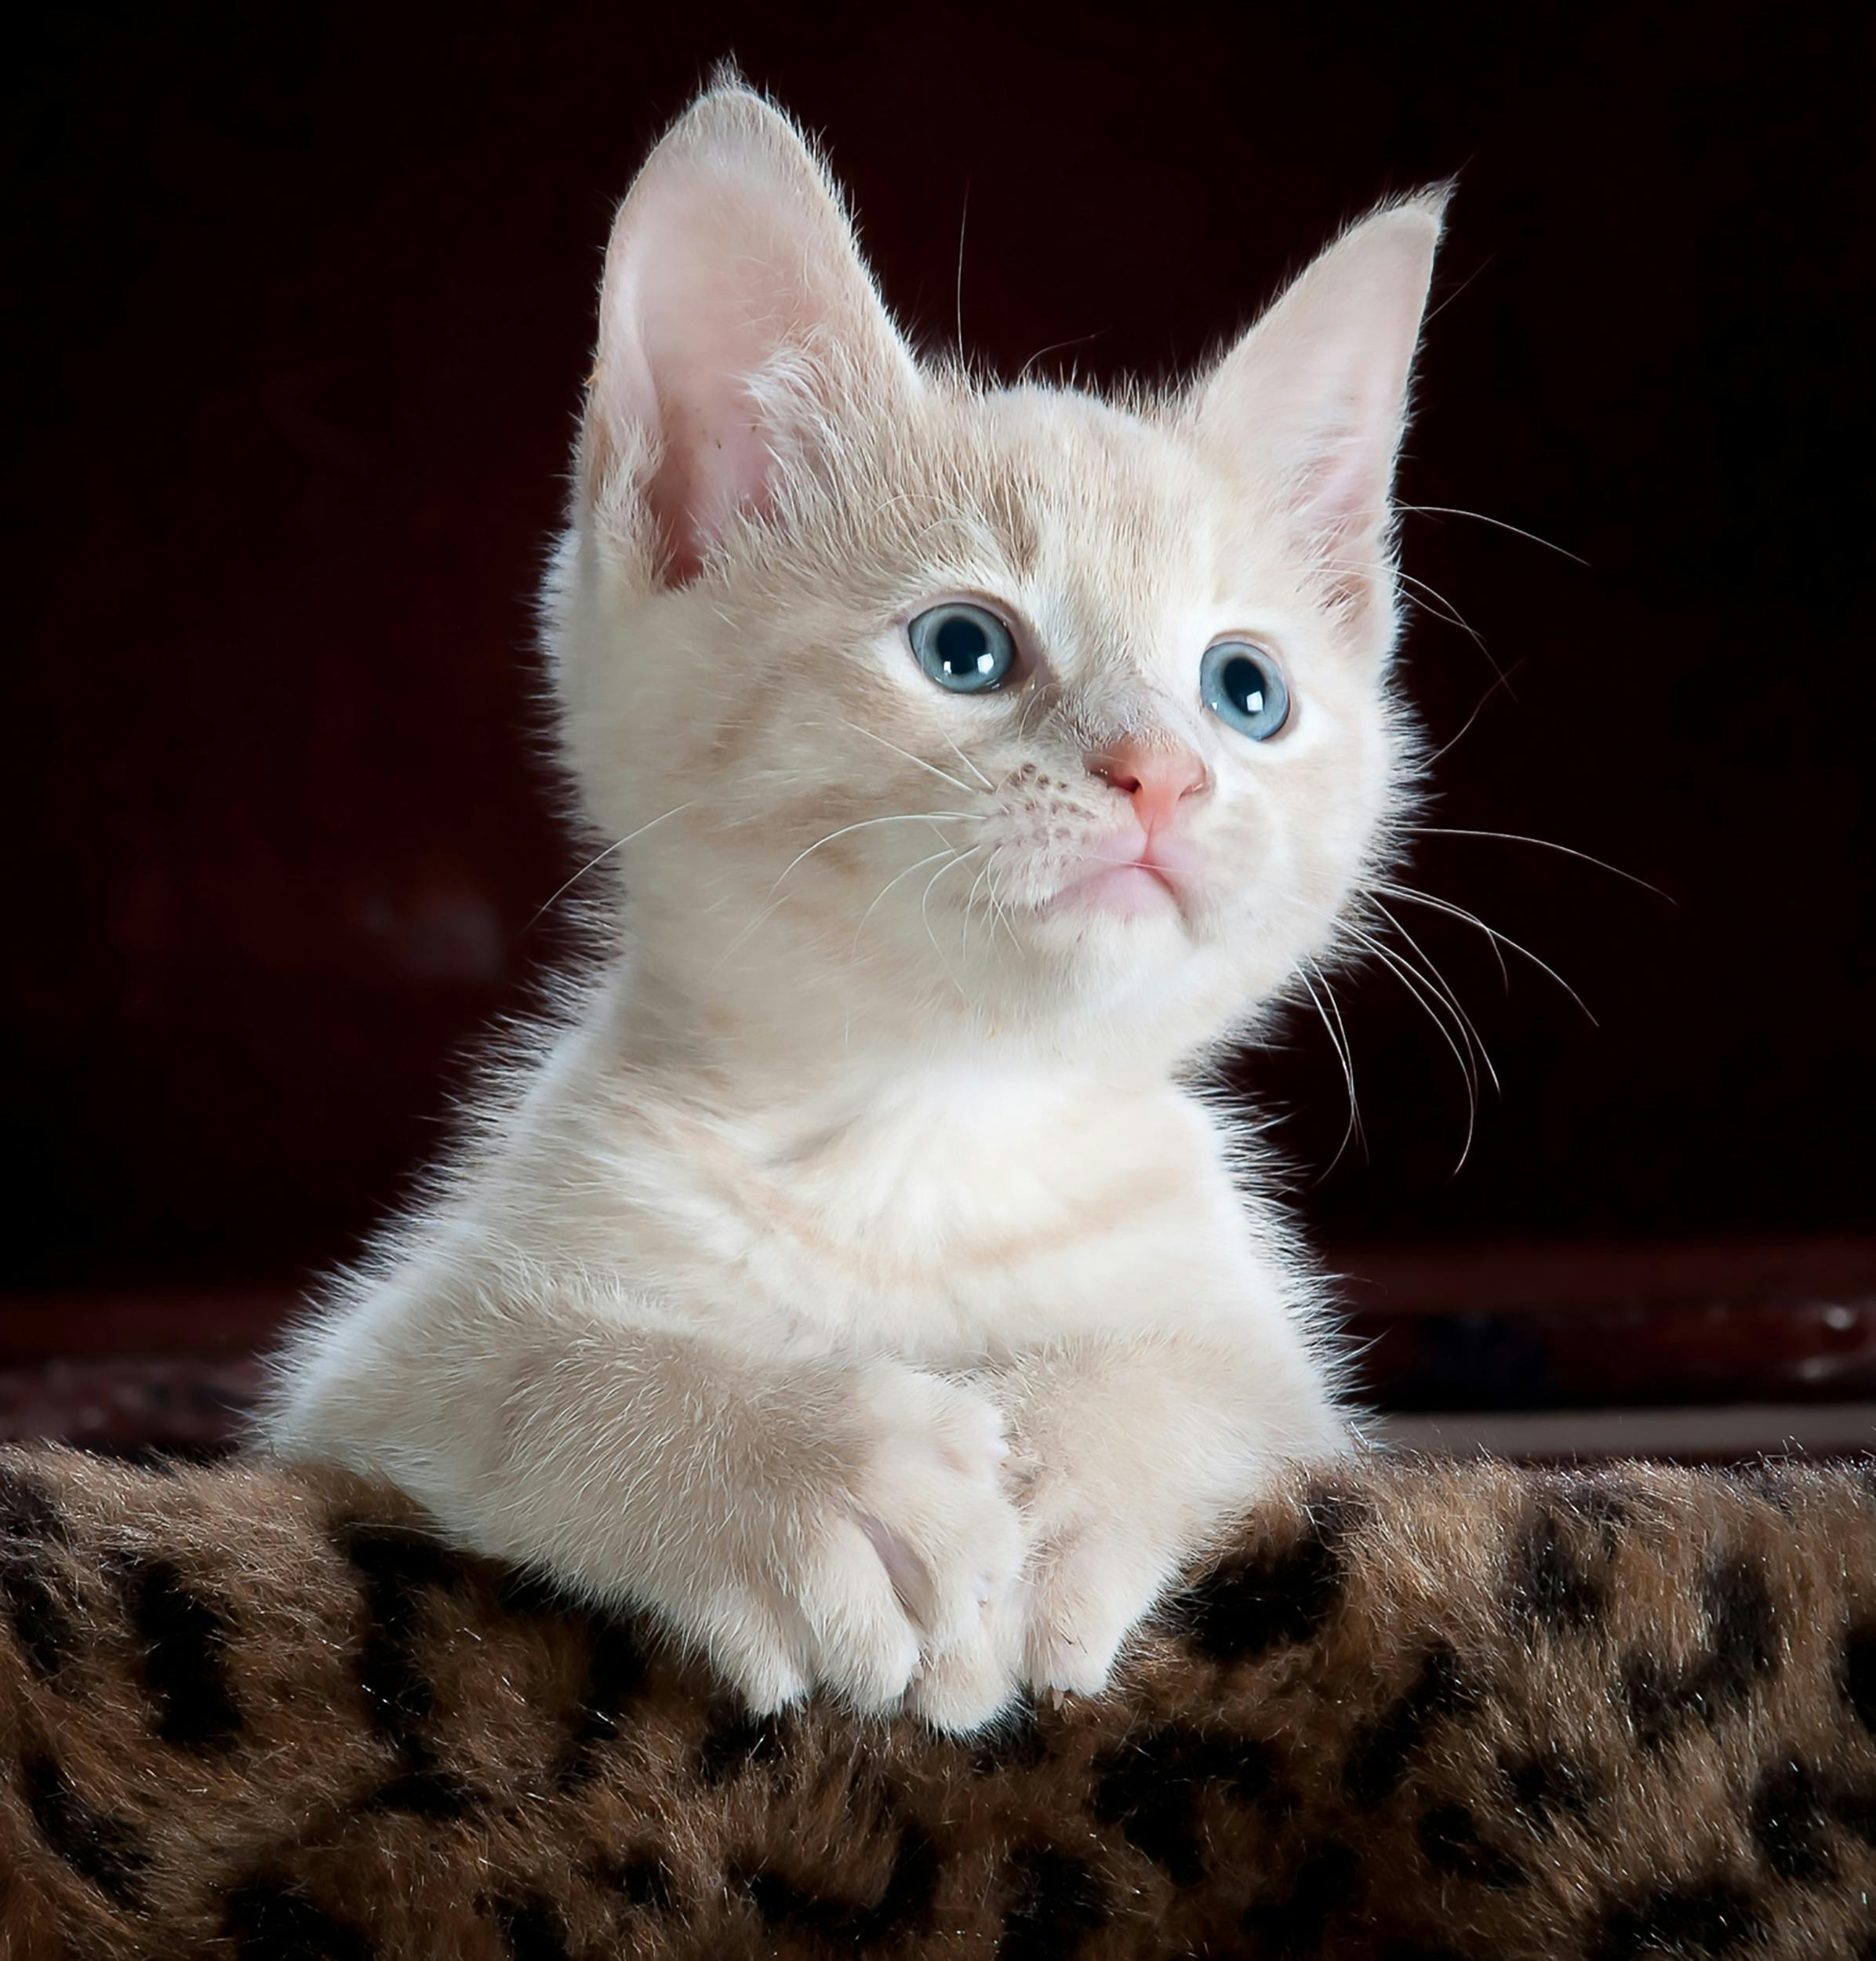

In [ ]:
CAT_IMG_SIZE = (299, 299)

display(Image(filename=cat_image_path, width=CAT_IMG_SIZE[0], height=CAT_IMG_SIZE[1]))

In [ ]:
def transform_image(image_path, size):
  img = image.load_img(image_path, target_size=size)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0) ## convert image to batch format, as keras/TF model expects batches of image.
  ### Before: 299 x 299 x 3
  ### After: 1 x 299 x 299 x 3
  img = xception_preprocess_input(img) ## convert each pixel to inbetween -1 and 1 or img/255.0
  return img

normalized_img = transform_image(cat_image_path, CAT_IMG_SIZE)
normalized_img

array([[[[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-0.9607843 , -0.99215686, -1.        ],
         [-0.96862745, -1.        , -1.        ],
         [-0.9607843 , -1.        , -1.        ]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-0.96862745, -1.        , -1.        ],
         [-0.96862745, -1.        , -1.        ],
         [-0.9607843 , -1.        , -1.        ]],

        [[-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         [-1.        , -1.        , -1.        ],
         ...,
         [-0.9607843 , -1.        , -1.        ],
         [-0.9529412 , -0.99215686, -1.        ],
         [-0.92941177, -1.        , -1.        ]],

        ...,

        [[-0.4823529 , -0.6862745 , -0

In [ ]:
xception_model = Xception(weights='imagenet')

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
The predicted class is : [[('n02123394', 'Persian_cat', np.float32(0.23971435))]]
Persian_cat


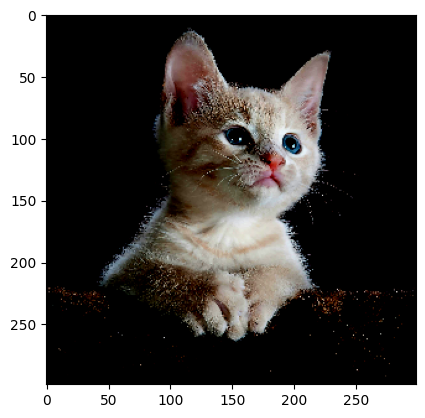

In [ ]:
def get_model_predictions(normalized_img, top_n:int):
  model_prediction = xception_model.predict(normalized_img)
  decode_model_prediction = xception_decode_predictions(model_prediction, top=top_n)
  print(f"The predicted class is : {decode_model_prediction}")
  return decode_model_prediction

plt.imshow(normalized_img[0])
top_prediction = get_model_predictions(normalized_img, 1)
print(top_prediction[0][0][1])

In [ ]:
top5_prediction = get_model_predictions(normalized_img, 5)

for pre in top5_prediction[0]:
  print(pre[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
The predicted class is : [[('n02123394', 'Persian_cat', np.float32(0.23971435)), ('n02124075', 'Egyptian_cat', np.float32(0.19466701)), ('n02123045', 'tabby', np.float32(0.1255615)), ('n02123159', 'tiger_cat', np.float32(0.01893697)), ('n02123597', 'Siamese_cat', np.float32(0.016769674))]]
Persian_cat
Egyptian_cat
tabby
tiger_cat
Siamese_cat


In [ ]:
explainer = lime_image.LimeImageExplainer()
explain_cat = explainer.explain_instance(
    normalized_img[0],
    xception_model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 

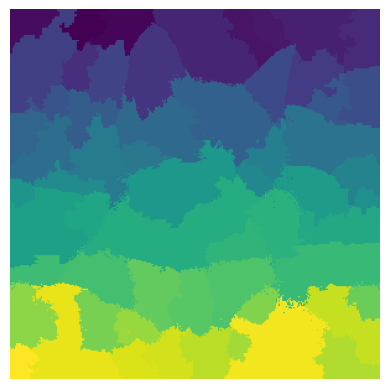

In [ ]:
plt.imshow(explain_cat.segments)
plt.axis('off')
plt.show()

In [ ]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, num_features = 6, show_positive = True, hide_background = True):
  image, mask = exp.get_image_and_mask(
      exp_class,
      positive_only=show_positive,
      num_features=num_features,
      hide_rest=hide_background,
      min_weight=weight
    )
  plt.imshow(mark_boundaries(image, mask))
  plt.axis('off')
  plt.show()

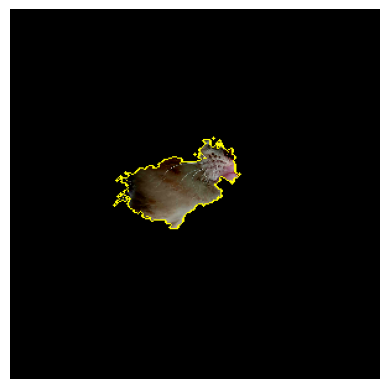

In [ ]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[0], show_positive=True, hide_background=True, num_features=6, weight=0.1)

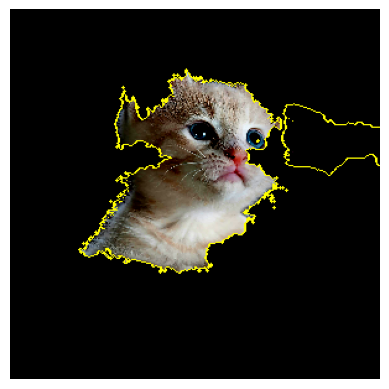

In [ ]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[0], show_positive=True, hide_background=True, num_features=6, weight=0.01)

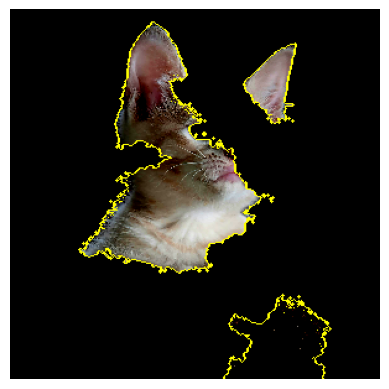

In [ ]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[1], show_positive=True, hide_background=True, num_features=6, weight=0.01)

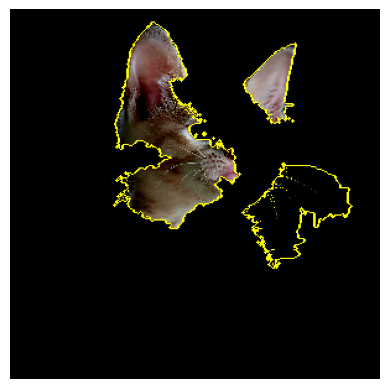

In [ ]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[2], show_positive=True, hide_background=True, num_features=6, weight=0.01)

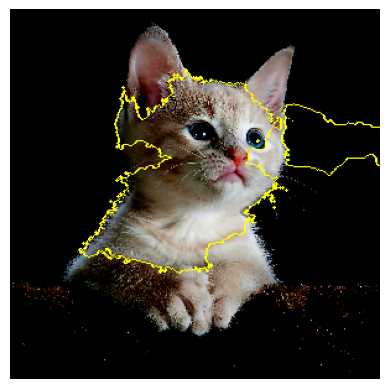

In [ ]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[0], show_positive=True, hide_background=False, num_features=6, weight=0.01)

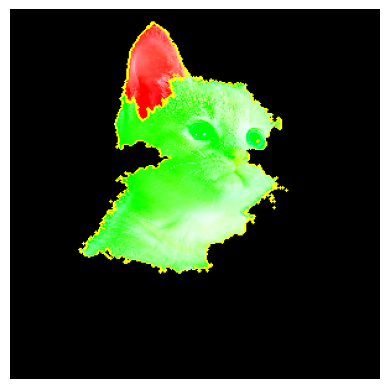

In [ ]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[0], show_positive=False, hide_background=True, num_features=6, weight=0.01)

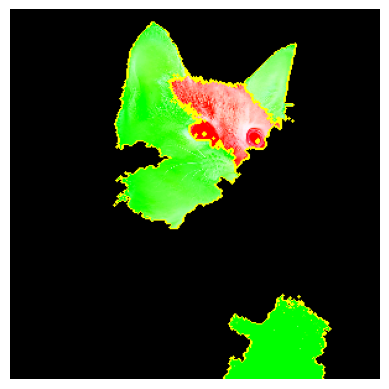

In [ ]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[1], show_positive=False, hide_background=True, num_features=6, weight=0.01)

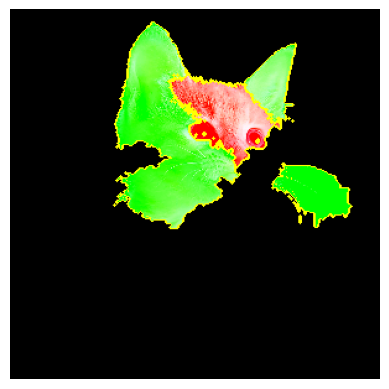

In [ ]:
generate_prediction_sample(explain_cat, explain_cat.top_labels[2], show_positive=False, hide_background=True, num_features=6, weight=0.01)

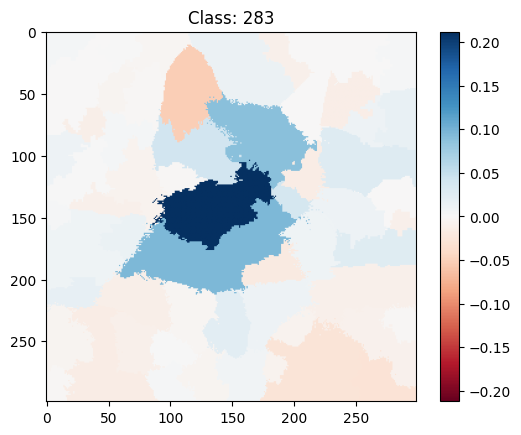

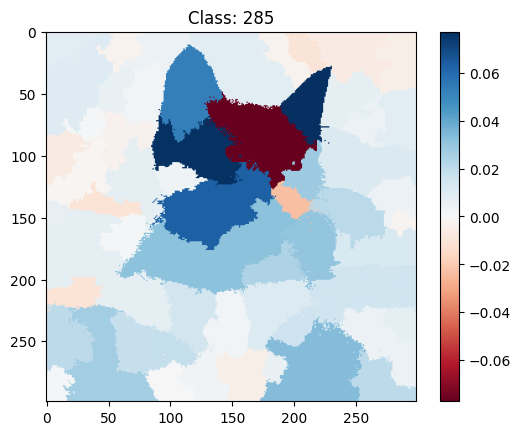

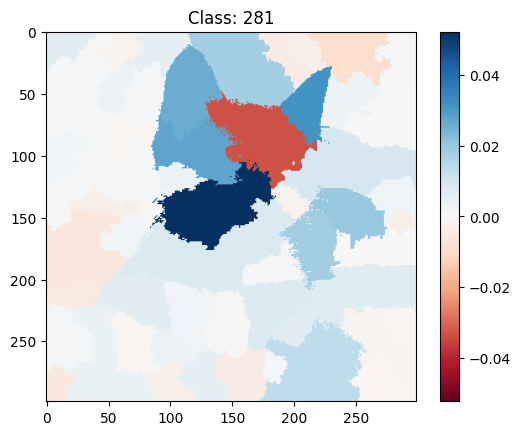

In [ ]:
def explanation_heatmap(exp, exp_class):
  dict_heatmap = dict(exp.local_exp[exp_class])
  heatmap = np.vectorize(dict_heatmap.get)(exp.segments)
  plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
  plt.colorbar()
  plt.title(f"Class: {exp_class}")
  plt.show()

for top5 in range(3):
  explanation_heatmap(explain_cat, explain_cat.top_labels[top5])


In [ ]:
resNet50 = ResNet50(weights="imagenet")
def transform_image_for_resnet50(image_path, size):
  img = image.load_img(image_path, target_size=size)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0) ## convert image to batch format, as keras/TF model expects batches of image.
  ### Before: 299 x 299 x 3
  ### After: 1 x 299 x 299 x 3
  img = resnet50_preprocess_input(img) ## convert each pixel to inbetween -1 and 1 or img/255.0
  return img

CAT_IMG_SIZE_FOR_RESNET = (224, 224)
normalized_img_resnet50 = transform_image_for_resnet50(cat_image_path, CAT_IMG_SIZE_FOR_RESNET)
normalized_img_resnet50

array([[[[-103.939   , -116.779   , -123.68    ],
         [-103.939   , -116.779   , -123.68    ],
         [-103.939   , -116.779   , -123.68    ],
         ...,
         [-103.939   , -115.779   , -118.68    ],
         [-103.939   , -115.779   , -118.68    ],
         [-103.939   , -116.779   , -118.68    ]],

        [[-103.939   , -116.779   , -123.68    ],
         [-103.939   , -116.779   , -123.68    ],
         [-103.939   , -116.779   , -123.68    ],
         ...,
         [-103.939   , -116.779   , -119.68    ],
         [-103.939   , -116.779   , -119.68    ],
         [-103.939   , -116.779   , -114.68    ]],

        [[-103.939   , -116.779   , -123.68    ],
         [-103.939   , -116.779   , -123.68    ],
         [-103.939   , -116.779   , -123.68    ],
         ...,
         [-103.939   , -116.779   , -119.68    ],
         [-103.939   , -116.779   , -118.68    ],
         [-103.939   , -116.779   , -114.68    ]],

        ...,

        [[ -84.939   ,  -82.779   ,  -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
The predicted class is : [[('n02124075', 'Egyptian_cat', np.float32(0.54931647))]]
Egyptian_cat


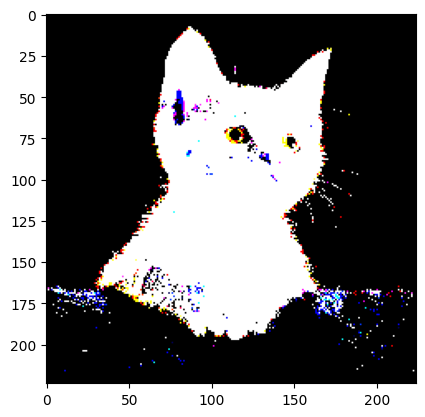

In [ ]:
def get_model_predictions_resnet50(normalized_img, top_n:int):
  model_prediction = resNet50.predict(normalized_img)
  decode_model_prediction = resnet50_decode_predictions(model_prediction, top=top_n)
  print(f"The predicted class is : {decode_model_prediction}")
  return decode_model_prediction

plt.imshow(normalized_img_resnet50[0])
top_prediction = get_model_predictions_resnet50(normalized_img_resnet50, 1)
print(top_prediction[0][0][1])

In [ ]:
top5_pred_from_resnet50 = get_model_predictions_resnet50(normalized_img_resnet50, 5)[0]

for pred in top5_pred_from_resnet50:
  print(pred[1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
The predicted class is : [[('n02124075', 'Egyptian_cat', np.float32(0.54931647)), ('n02123045', 'tabby', np.float32(0.14852613)), ('n02123394', 'Persian_cat', np.float32(0.0833373)), ('n02127052', 'lynx', np.float32(0.05500464)), ('n02123159', 'tiger_cat', np.float32(0.018742366))]]
Egyptian_cat
tabby
Persian_cat
lynx
tiger_cat


In [ ]:
explainer_cat = explainer.explain_instance(
    normalized_img_resnet50[0],
    resNet50.predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
  )

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

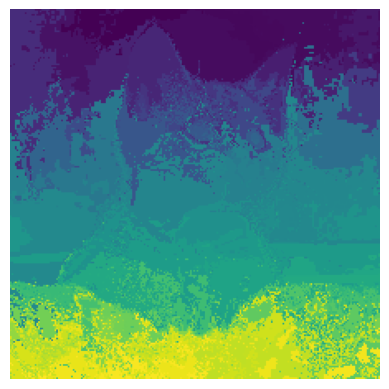

In [ ]:
plt.imshow(explainer_cat.segments)
plt.axis('off')
plt.show()

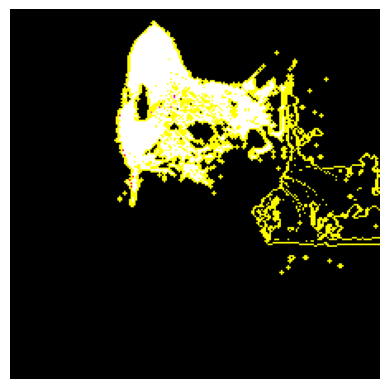

In [ ]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[0], show_positive=True, hide_background=True, num_features=6, weight=0.01)

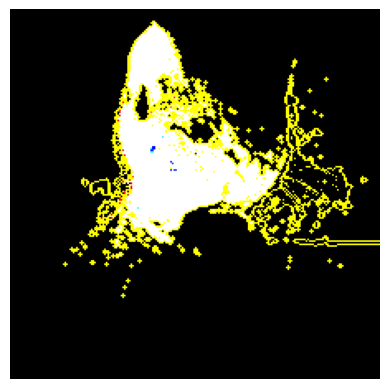

In [ ]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[1], show_positive=True, hide_background=True, num_features=6, weight=0.001)

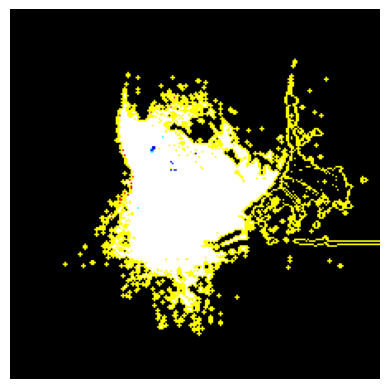

In [ ]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[2], show_positive=True, hide_background=True, num_features=6, weight=0.001)

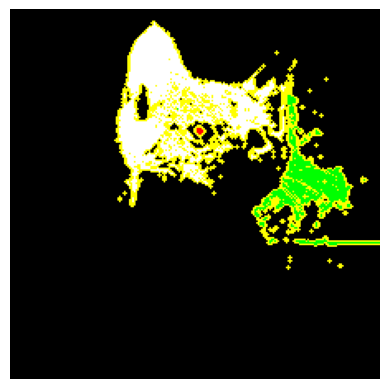

In [ ]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[0], show_positive=False, hide_background=True, num_features=6, weight=0.01)

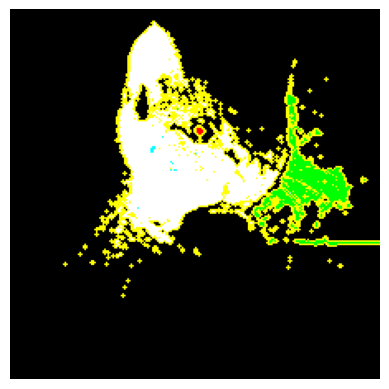

In [ ]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[1], show_positive=False, hide_background=True, num_features=6, weight=0.001)

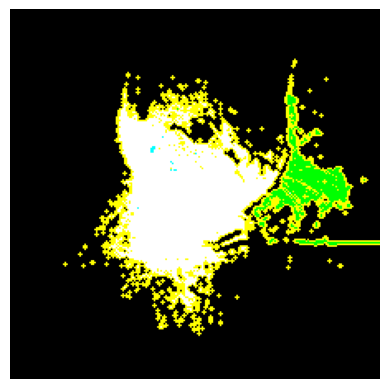

In [ ]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[2], show_positive=False, hide_background=True, num_features=6, weight=0.001)

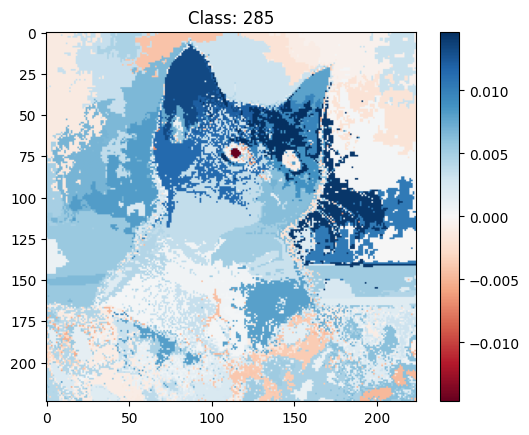

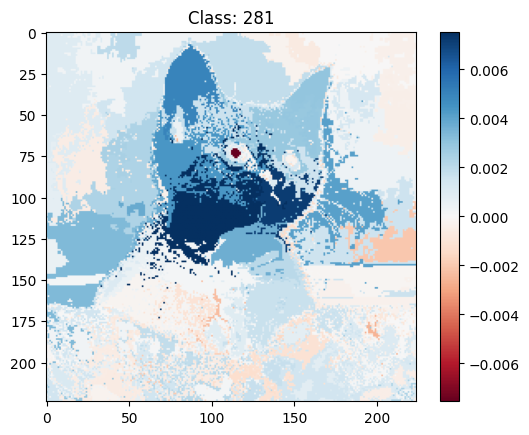

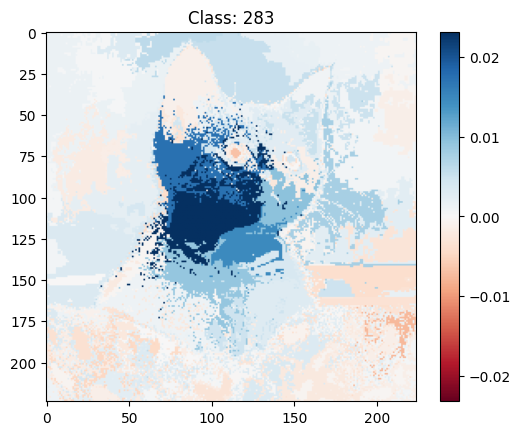

In [ ]:
explanation_heatmap(explainer_cat, explainer_cat.top_labels[0])
explanation_heatmap(explainer_cat, explainer_cat.top_labels[1])
explanation_heatmap(explainer_cat, explainer_cat.top_labels[2])

In [ ]:
vgg19_model = VGG19(weights='imagenet')

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
def transform_image_for_vgg19(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = vgg19_preprocess_input(img)

    return img

CAT_IMG_SIZE_VGG19 = (224, 224)
normalized_img_vg99 = transform_image_for_vgg19(cat_image_path, CAT_IMG_SIZE_VGG19)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
The predicted class is : [[('n02124075', 'Egyptian_cat', np.float32(0.44007415))]]
Egyptian_cat


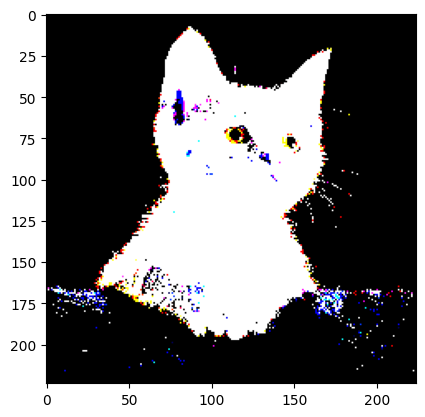

In [ ]:
def get_model_predictions_vgg19(data, top_n: int):
    model_prediction = vgg19_model.predict(data)
    decode_predictions_val = vgg19_decode_predictions(model_prediction, top=top_n)
    print(f"The predicted class is : {decode_predictions_val}")
    return decode_predictions_val

plt.imshow(normalized_img_vg99[0])
top_prediction = get_model_predictions_vgg19(normalized_img_vg99, 1)
print(top_prediction[0][0][1])


In [ ]:
explainer_cat = explainer.explain_instance(
    normalized_img_vg99[0],
    vgg19_model.predict,
    top_labels=5,
    hide_color=0,
    num_samples=1000
  )

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 

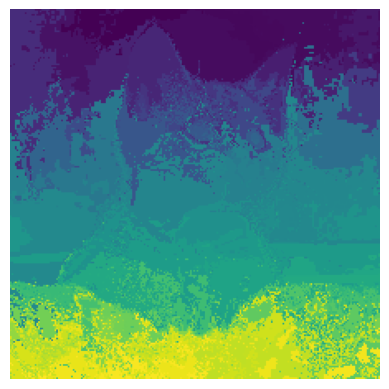

In [ ]:
plt.imshow(explainer_cat.segments)
plt.axis('off')
plt.show()

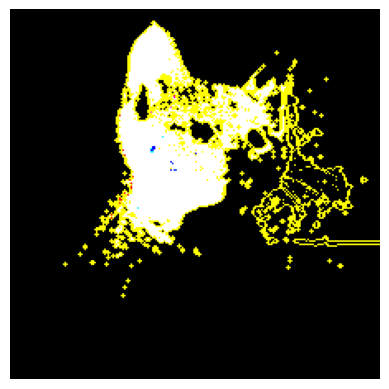

In [ ]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[0], show_positive = True, hide_background = True, weight=0.001)

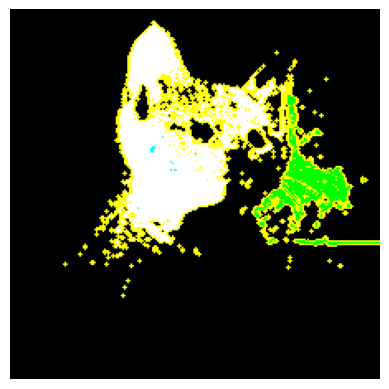

In [ ]:
generate_prediction_sample(explainer_cat, explainer_cat.top_labels[0], show_positive = False, hide_background = True, weight=0.001)

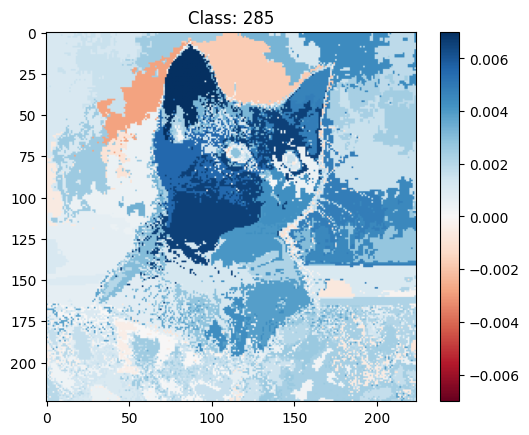

In [ ]:
explanation_heatmap(explainer_cat, explainer_cat.top_labels[0])

In [ ]:
pip install shap

In [ ]:
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import shap

In [ ]:
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")
path

Using Colab cache for faster access to the 'heart-disease-data' dataset.


'/kaggle/input/heart-disease-data'

In [ ]:
heart_disease_df = pd.read_csv("/kaggle/input/heart-disease-data/heart_disease_uci.csv")
heart_disease_df.head()

id  age     sex    dataset               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0

In [ ]:
heart_disease_df = heart_disease_df.drop(columns=['id', 'dataset'])

In [ ]:
heart_disease_df.head()

age     sex               cp  trestbps   chol    fbs         restecg  \
0   63    Male   typical angina     145.0  233.0   True  lv hypertrophy   
1   67    Male     asymptomatic     160.0  286.0  False  lv hypertrophy   
2   67    Male     asymptomatic     120.0  229.0  False  lv hypertrophy   
3   37    Male      non-anginal     130.0  250.0  False          normal   
4   41  Female  atypical angina     130.0  204.0  False  lv hypertrophy   

   thalch  exang  oldpeak        slope   ca               thal  num  
0   150.0  False      2.3  downsloping  0.0       fixed defect    0  
1   108.0   True      1.5         flat  3.0             normal    2  
2   129.0   True      2.6         flat  2.0  reversable defect    1  
3   187.0  False      3.5  downsloping  0.0             normal    0  
4   172.0  False      1.4    upsloping  0.0             normal    0

In [ ]:
le = LabelEncoder()

for col in heart_disease_df.select_dtypes(include=['object', 'bool']).columns:
  heart_disease_df[col] = le.fit_transform(heart_disease_df[col])

heart_disease_df.head()

age  sex  cp  trestbps   chol  fbs  restecg  thalch  exang  oldpeak  slope  \
0   63    1   3     145.0  233.0    1        0   150.0      0      2.3      0   
1   67    1   0     160.0  286.0    0        0   108.0      1      1.5      1   
2   67    1   0     120.0  229.0    0        0   129.0      1      2.6      1   
3   37    1   2     130.0  250.0    0        1   187.0      0      3.5      0   
4   41    0   1     130.0  204.0    0        0   172.0      0      1.4      2   

    ca  thal  num  
0  0.0     0    0  
1  3.0     1    2  
2  2.0     2    1  
3  0.0     1    0  
4  0.0     1    0

In [ ]:
X = heart_disease_df.drop('num', axis=1) ### Feature columns
X.head()

age  sex  cp  trestbps   chol  fbs  restecg  thalch  exang  oldpeak  slope  \
0   63    1   3     145.0  233.0    1        0   150.0      0      2.3      0   
1   67    1   0     160.0  286.0    0        0   108.0      1      1.5      1   
2   67    1   0     120.0  229.0    0        0   129.0      1      2.6      1   
3   37    1   2     130.0  250.0    0        1   187.0      0      3.5      0   
4   41    0   1     130.0  204.0    0        0   172.0      0      1.4      2   

    ca  thal  
0  0.0     0  
1  3.0     1  
2  2.0     2  
3  0.0     1  
4  0.0     1

In [ ]:
y = (heart_disease_df['num'] > 0).astype(int) ## Prediction values
y

0      0
1      1
2      1
3      0
4      0
      ..
915    1
916    0
917    1
918    0
919    1
Name: num, Length: 920, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
random_forest_model = RandomForestClassifier(max_features=2, n_estimators=100, bootstrap=True)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(max_features=2)

In [ ]:
y_prediction = random_forest_model.predict(X_test)
print(classification_report(y_prediction, y_test))

              precision    recall  f1-score   support

           0       0.85      0.78      0.82        82
           1       0.83      0.89      0.86       102

    accuracy                           0.84       184
   macro avg       0.84      0.84      0.84       184
weighted avg       0.84      0.84      0.84       184



In [ ]:
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(random_forest_model)
shap_values = explainer(X_test)

# 1. Global bar plot

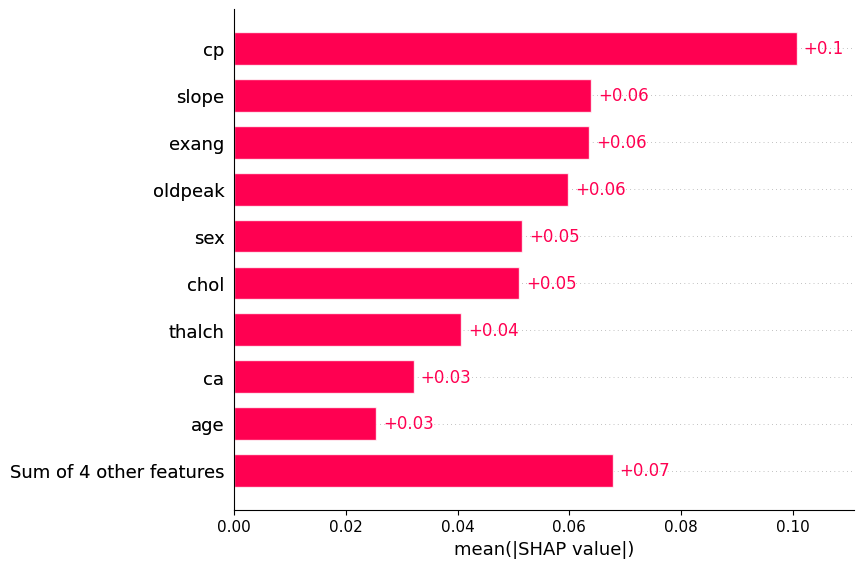

In [ ]:
shap.plots.bar(shap_values[..., 1])

# 2. Local bar plot

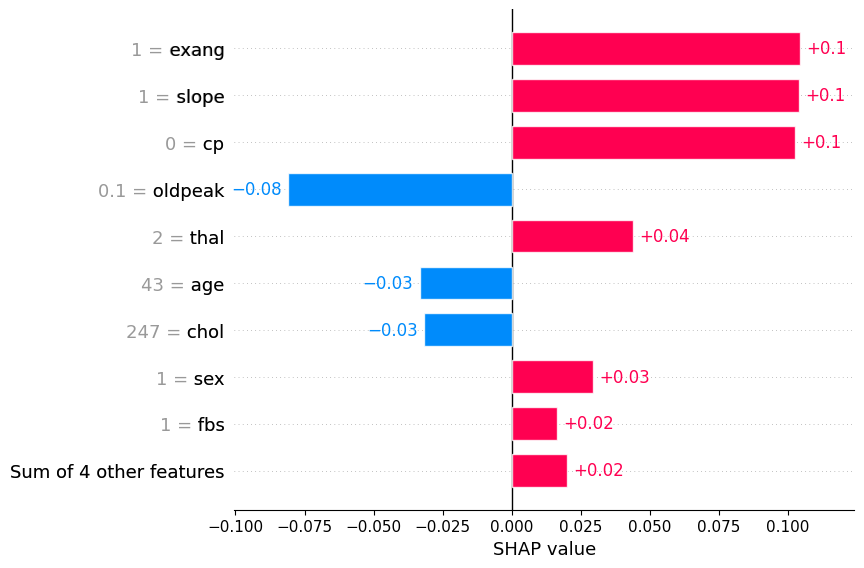

In [ ]:
shap.plots.bar(shap_values[10][..., 1])

# 3. Local Waterfall

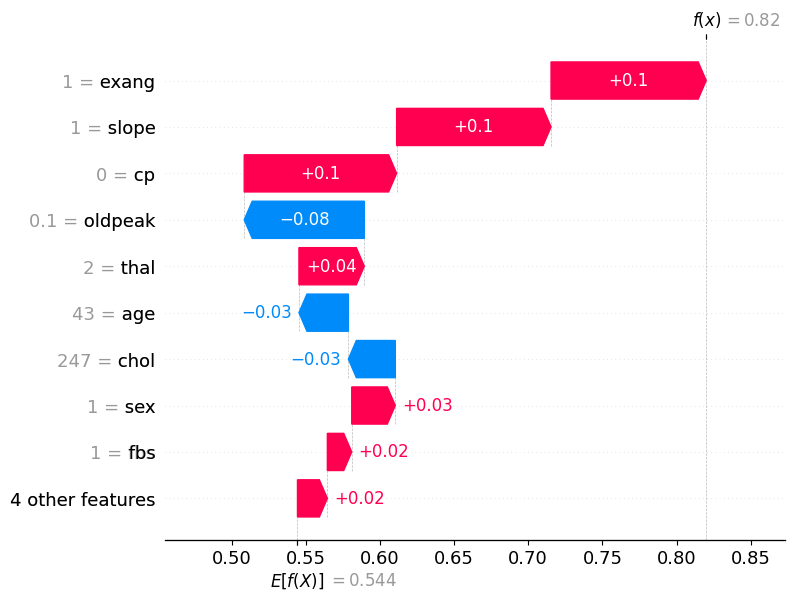

In [ ]:
shap.plots.waterfall(shap_values[10][..., 1])

# 4. Beeswarm plot

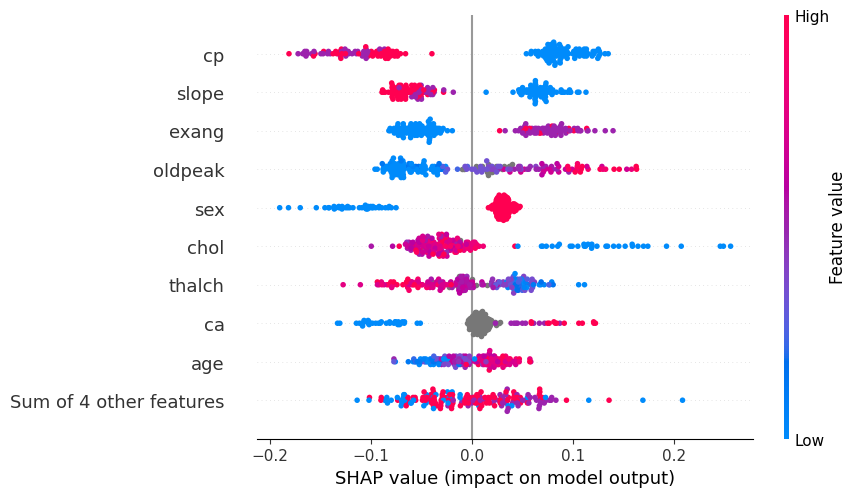

In [ ]:
shap.plots.beeswarm(shap_values[..., 1])

# 5. Dependence scatter plot

**For Age:**

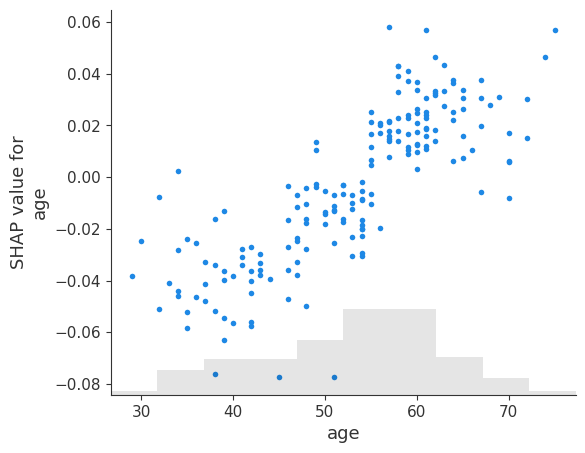

In [ ]:
feature = "age"
age_idx = list(X_train.columns).index(feature)

shap.plots.scatter(shap_values[:, age_idx, 1])

**For Sex**

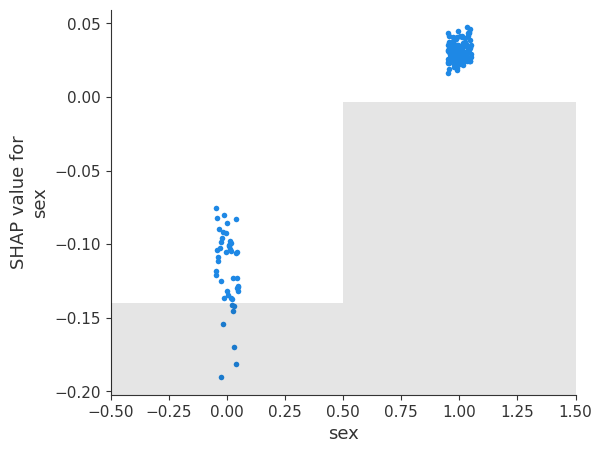

In [ ]:
feature = "sex"
age_idx = list(X_train.columns).index(feature)

shap.plots.scatter(shap_values[:, age_idx, 1])

In [ ]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
# Get the class names
class_names = ['Has diabetes', 'No diabetes']

# Get the feature names
feature_names = list(X_train.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train.values, feature_names =
                                 feature_names,
                                 class_names = class_names,
                                 mode = 'classification')

In [ ]:
#Perform the explanation on the 8th instance in the test data
explaination = explainer.explain_instance(X_test.iloc[8], random_forest_model.predict_proba)

# show the result of the model's explaination
explaination.show_in_notebook(show_table = True, show_all = False)

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.truncnorm` documentation for details.